In [0]:
from google.colab import drive
drive.mount('/content/drive')




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

170500096it [00:05, 29208352.24it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

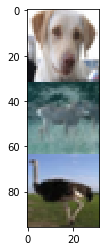

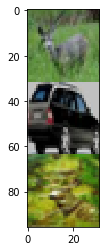

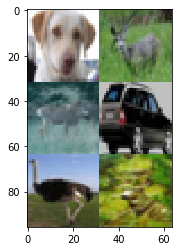

torch.Size([3, 96, 32])


In [7]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



4


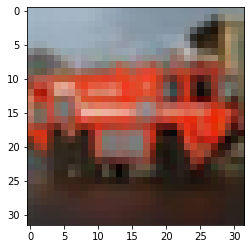

truck


In [10]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 200
every_what_epoch = 5
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
    print(epoch,"updating where_net, what_net is freezed") 
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
    print(epoch,"updating what_net, where_net is freezed")
      
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        optimizer_where.step()
          
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        optimizer_what.step()
          
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10154.0 Total: 30000 train_loss 1.1139146225292158 train_acc:  0.3384666666666667
total_Correct: 3287.0 Total: 10000 test loss:  1.1156024578764394 test accuracy 0.3287
1 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10154.0 Total: 30000 train_loss 1.1139146224126664 train_acc:  0.3384666666666667
total_Correct: 3287.0 Total: 10000 test loss:  1.1156024577922767 test accuracy 0.3287
2 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10154.0 Total: 30000 train_loss 1.113914622294651 train_acc:  0.3384666666666667
total_Correct: 3287.0 Total: 10000 test loss:  1.1156024577104382 test accuracy 0.3287
3 updating where_net, what_net is freezed
--------

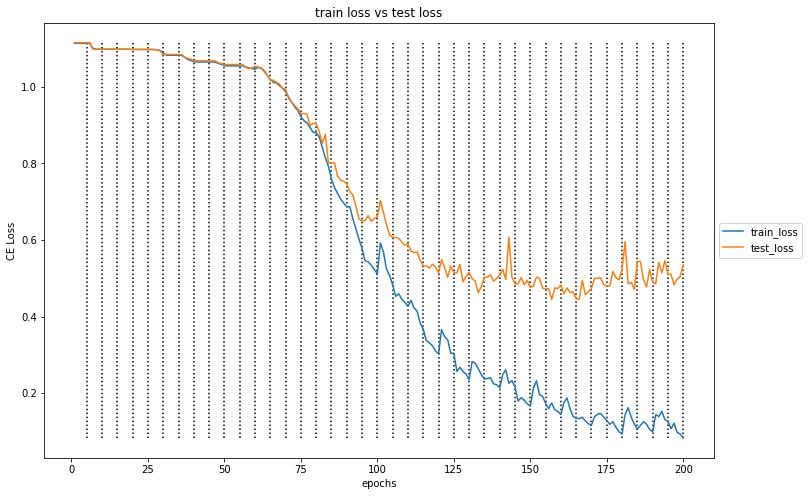

In [21]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


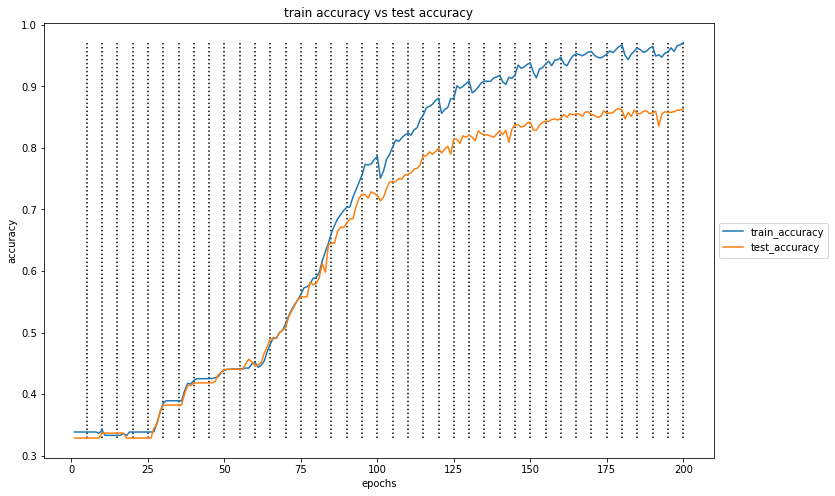

In [22]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [24]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   2098                   17748
1        5             0  ...                   2100                   17746
2       10             0  ...                   2390                   17618
3       15             0  ...                   2395                   17613
4       20             0  ...                   2107                   17739
5       25             0  ...                   2127                   17719
6       30             0  ...                   1981                   16342
7       35             0  ...                   2139                   16185
8       40             0  ...                   2341                   14907
9       45             0  ...                   3681                   13558
10      50             0  ...                   3261                   13530
11      55             0  ...                   3398                   13369
12      60             0  ...                   3605                   13085
13      65           228  ...                   4165                   11080
14      70          1132  ...                   3478                   10713
15      75          4275  ...                   3446                    9377
16      80          6528  ...                   2766                    9308
17      85         15076  ...                   3002                    6781
18      90         16202  ...                   2309                    6571
19      95         20248  ...                   2155                    4647
20     100         19986  ...                   2001                    5480
21     105         22885  ...                   1498                    4122
22     110         21802  ...                   1351                    4032
23     115         24000  ...                   1189                    2857
24     120         23929  ...                   1011                    3312
25     125         26150  ...                    787                    2189
26     130         25072  ...                    831                    2486
27     135         25589  ...                    796                    1962
28     140         25052  ...                    616                    2170
29     145         26205  ...                    409                    1556
30     150         25805  ...                    508                    1814
31     155         26555  ...                    393                    1385
32     160         25963  ...                    448                    1457
33     165         26413  ...                    377                    1078
34     170         26291  ...                    422                    1080
35     175         26447  ...                    373                     900
36     180         25381  ...                    346                    1155
37     185         26467  ...                    231                     990
38     190         26408  ...                    350                    1183
39     195         27085  ...                    251                     877

[40 rows x 7 columns]

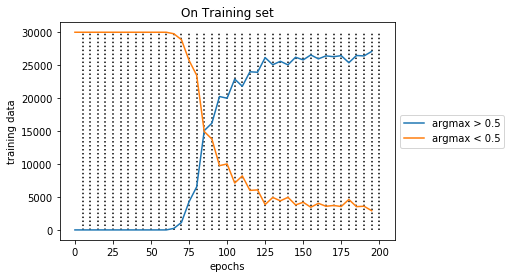

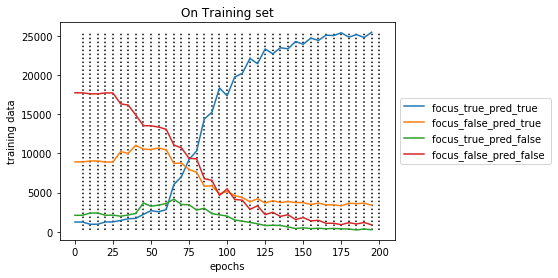

In [25]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [26]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    696                    6017
1        5             0  ...                    696                    6017
2       10             0  ...                    772                    5861
3       15             0  ...                    776                    5857
4       20             0  ...                    702                    6011
5       25             0  ...                    700                    6013
6       30             0  ...                    652                    5525
7       35             0  ...                    694                    5484
8       40             0  ...                    849                    4970
9       45             0  ...                   1332                    4485
10      50             0  ...                   1080                    4520
11      55             0  ...                   1022                    4572
12      60             0  ...                   1424                    4104
13      65            78  ...                   1351                    3752
14      70           389  ...                   1193                    3552
15      75          1372  ...                   1198                    3222
16      80          1346  ...                   1063                    3048
17      85          4981  ...                   1020                    2527
18      90          5202  ...                    860                    2294
19      95          6621  ...                    810                    1947
20     100          7218  ...                    712                    2151
21     105          7464  ...                    652                    1896
22     110          6684  ...                    614                    1794
23     115          7726  ...                    560                    1570
24     120          7922  ...                    520                    1563
25     125          8523  ...                    442                    1415
26     130          8144  ...                    457                    1370
27     135          8240  ...                    418                    1373
28     140          8073  ...                    365                    1419
29     145          8480  ...                    317                    1308
30     150          7876  ...                    415                    1296
31     155          8523  ...                    338                    1231
32     160          8335  ...                    366                    1093
33     165          8417  ...                    302                    1147
34     170          8474  ...                    346                    1128
35     175          8395  ...                    334                    1103
36     180          8236  ...                    291                    1238
37     185          8516  ...                    280                    1164
38     190          8372  ...                    332                    1073
39     195          8629  ...                    294                    1129

[40 rows x 7 columns]

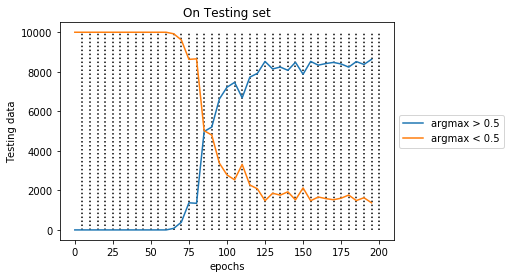

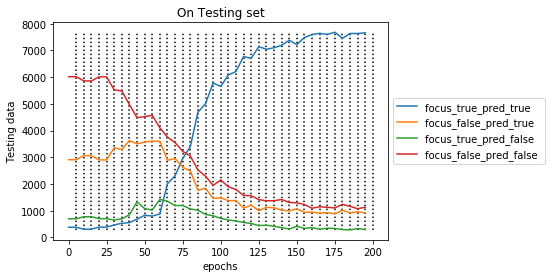

In [27]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [28]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 228, 1132, 4275, 6528, 15076, 16202, 20248, 19986, 22885, 21802, 24000, 23929, 26150, 25072, 25589, 25052, 26205, 25805, 26555, 25963, 26413, 26291, 26447, 25381, 26467, 26408, 27085]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 29772, 28868, 25725, 23472, 14924, 13798, 9752, 10014, 7115, 8198, 6000, 6071, 3850, 4928, 4411, 4948, 3795, 4195, 3445, 4037, 3587, 3709, 3553, 4619, 3533, 3592, 2915]
focus_true_pred_true [1237, 1240, 951, 958, 1246, 1253, 1443, 1655, 1707, 2215, 2698, 2543, 2836, 6030, 7042, 9227, 10337, 14409, 15252, 18380, 17361, 19771, 20235, 22138, 21466, 23356, 22723, 23504, 23369, 24303, 23951, 24742, 24438, 25118, 

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_200_every5epochs_lr_01_focus_vs_pred/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


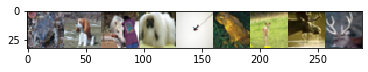

tensor([8.4845e-03, 1.3710e-02, 9.6732e-01, 2.8312e-03, 3.2003e-04, 1.2310e-03,
        4.7629e-04, 9.1566e-04, 4.7155e-03], device='cuda:0',
       dtype=torch.float64)


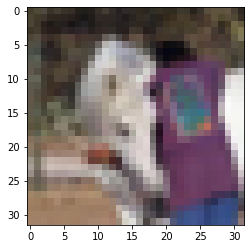

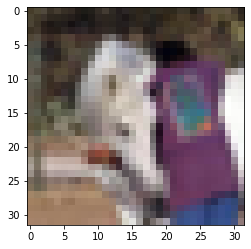

predicted horse
true horse
****************************************************************************************************


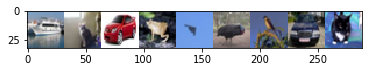

tensor([9.7232e-01, 3.4934e-04, 1.6245e-05, 2.4352e-04, 4.1892e-06, 1.3451e-04,
        4.6344e-05, 2.6886e-02, 2.5028e-06], device='cuda:0',
       dtype=torch.float64)


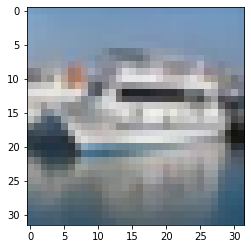

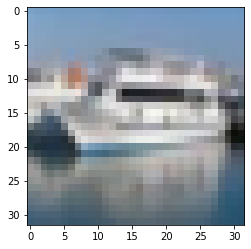

predicted ship
true ship
****************************************************************************************************


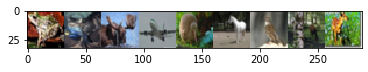

tensor([1.1069e-04, 8.5103e-02, 9.9825e-03, 4.0921e-01, 2.7344e-03, 4.6379e-01,
        1.4320e-02, 5.5978e-03, 9.1483e-03], device='cuda:0',
       dtype=torch.float64)


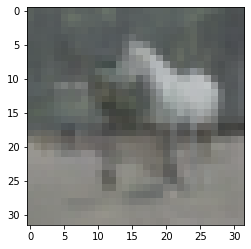

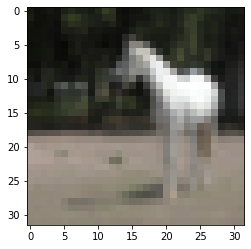

predicted horse
true horse
****************************************************************************************************


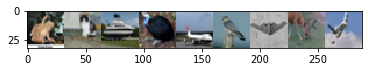

tensor([2.2462e-04, 3.4363e-04, 9.9900e-01, 5.5271e-05, 2.3711e-04, 2.2587e-05,
        7.9488e-05, 3.0574e-05, 5.1056e-06], device='cuda:0',
       dtype=torch.float64)


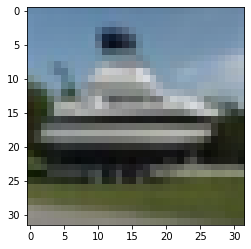

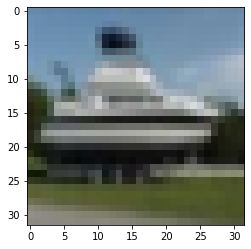

predicted ship
true ship
****************************************************************************************************


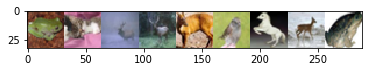

tensor([0.0626, 0.0744, 0.1047, 0.3329, 0.1867, 0.0553, 0.0943, 0.0797, 0.0093],
       device='cuda:0', dtype=torch.float64)


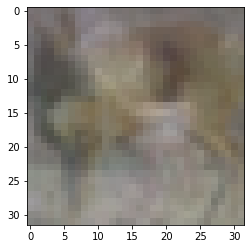

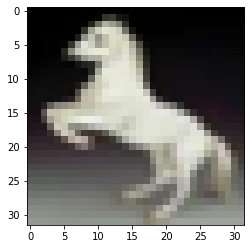

predicted horse
true horse
****************************************************************************************************


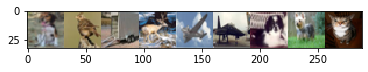

tensor([3.3345e-04, 1.6667e-04, 9.9120e-01, 1.8743e-03, 9.8500e-05, 5.0189e-03,
        7.1505e-05, 1.1933e-03, 4.2274e-05], device='cuda:0',
       dtype=torch.float64)


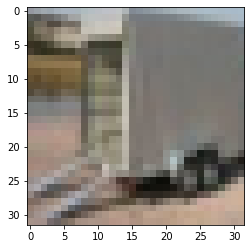

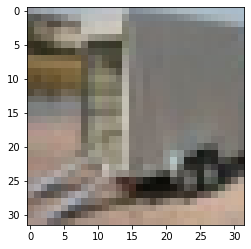

predicted truck
true truck
****************************************************************************************************


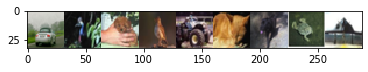

tensor([0.9343, 0.0189, 0.0028, 0.0038, 0.0075, 0.0032, 0.0047, 0.0072, 0.0175],
       device='cuda:0', dtype=torch.float64)


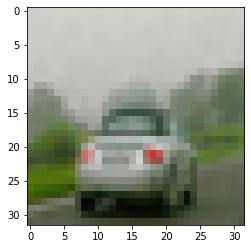

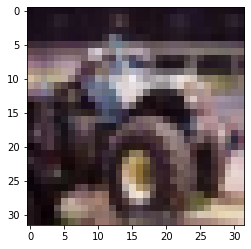

predicted truck
true truck
****************************************************************************************************


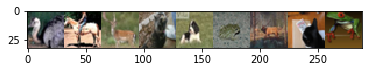

tensor([0.0016, 0.9309, 0.0095, 0.0060, 0.0149, 0.0037, 0.0253, 0.0034, 0.0046],
       device='cuda:0', dtype=torch.float64)


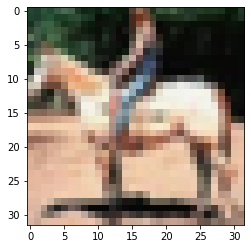

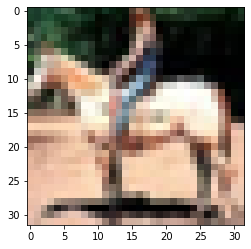

predicted horse
true horse
****************************************************************************************************


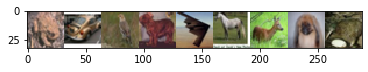

tensor([1.4042e-03, 2.6945e-03, 1.8122e-03, 8.3895e-04, 1.0142e-04, 9.8459e-01,
        1.0024e-03, 6.1503e-03, 1.4070e-03], device='cuda:0',
       dtype=torch.float64)


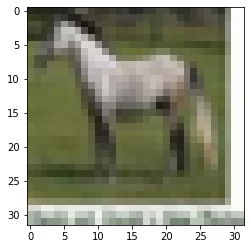

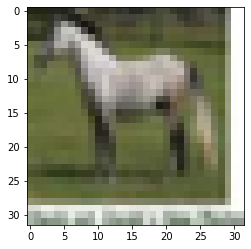

predicted horse
true horse
****************************************************************************************************


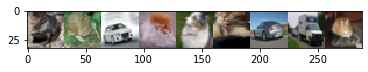

tensor([7.3439e-04, 2.0836e-03, 2.7539e-04, 4.5505e-04, 6.2522e-04, 1.0204e-02,
        7.8797e-03, 9.7712e-01, 6.2342e-04], device='cuda:0',
       dtype=torch.float64)


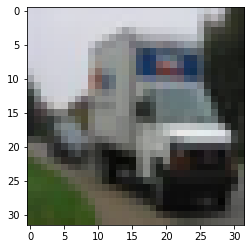

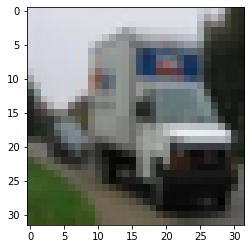

predicted truck
true truck
****************************************************************************************************


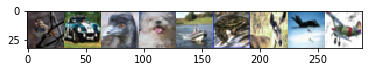

tensor([2.3869e-02, 2.7672e-03, 5.2928e-02, 1.1106e-02, 8.9242e-01, 7.1629e-04,
        1.0360e-02, 1.6324e-03, 4.1998e-03], device='cuda:0',
       dtype=torch.float64)


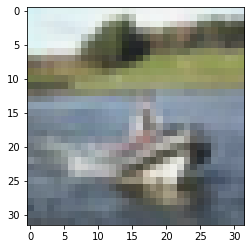

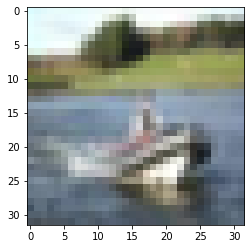

predicted ship
true ship
****************************************************************************************************


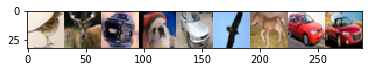

tensor([3.1965e-03, 3.8772e-03, 1.4529e-01, 3.2847e-03, 2.5509e-03, 1.6804e-04,
        6.1442e-01, 6.3112e-02, 1.6410e-01], device='cuda:0',
       dtype=torch.float64)


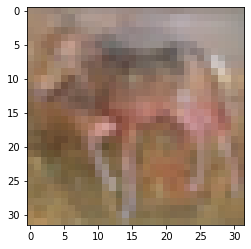

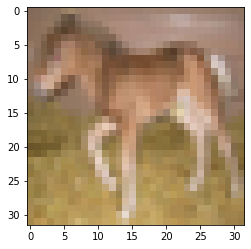

predicted horse
true horse
****************************************************************************************************


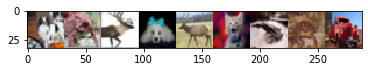

tensor([9.3867e-05, 3.3339e-04, 7.2841e-05, 3.2994e-04, 4.7872e-05, 1.8582e-04,
        6.4094e-05, 5.4590e-04, 9.9833e-01], device='cuda:0',
       dtype=torch.float64)


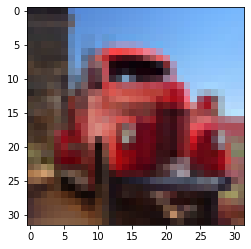

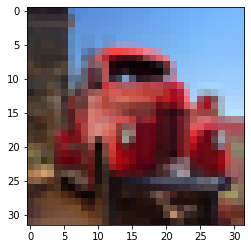

predicted truck
true truck
****************************************************************************************************


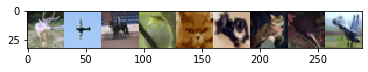

tensor([6.5612e-05, 1.3757e-05, 9.9802e-01, 6.6900e-06, 4.5380e-05, 1.0508e-04,
        1.2631e-03, 6.7393e-05, 4.1414e-04], device='cuda:0',
       dtype=torch.float64)


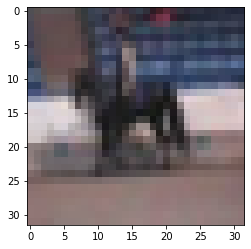

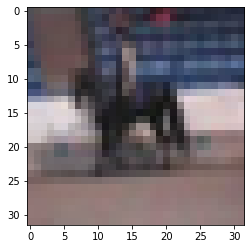

predicted horse
true horse
****************************************************************************************************


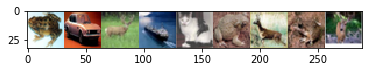

tensor([0.0031, 0.0027, 0.0300, 0.8058, 0.0985, 0.0043, 0.0171, 0.0091, 0.0293],
       device='cuda:0', dtype=torch.float64)


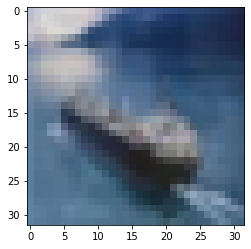

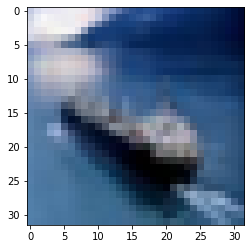

predicted ship
true ship
****************************************************************************************************


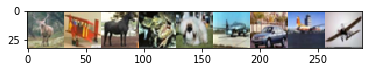

tensor([1.2262e-09, 9.4411e-11, 1.0000e+00, 5.5188e-11, 1.5869e-11, 9.7775e-10,
        8.5636e-10, 3.1432e-10, 2.0267e-11], device='cuda:0',
       dtype=torch.float64)


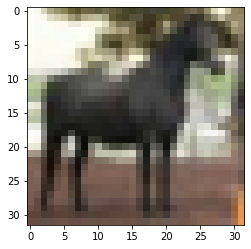

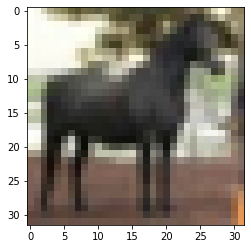

predicted horse
true horse
****************************************************************************************************


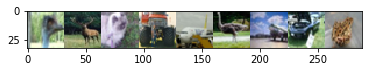

tensor([4.1718e-04, 3.2859e-04, 6.9628e-05, 9.9625e-01, 1.8255e-04, 3.7992e-04,
        3.7955e-04, 4.8984e-06, 1.9845e-03], device='cuda:0',
       dtype=torch.float64)


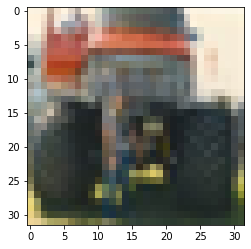

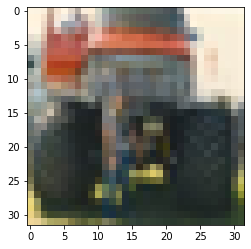

predicted truck
true truck
****************************************************************************************************


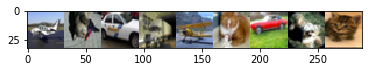

tensor([2.8299e-04, 8.2958e-04, 4.4312e-03, 9.8378e-01, 8.7184e-03, 1.1752e-04,
        1.5366e-03, 1.7288e-04, 1.3457e-04], device='cuda:0',
       dtype=torch.float64)


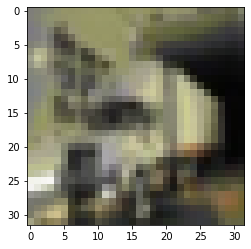

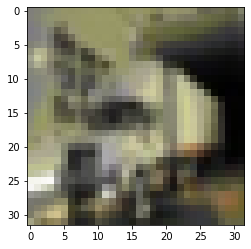

predicted truck
true truck
****************************************************************************************************


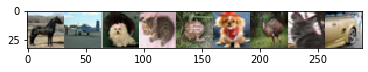

tensor([1.0000e+00, 4.8503e-07, 5.7099e-07, 8.1224e-08, 1.8686e-07, 1.1209e-07,
        4.6989e-07, 6.4221e-08, 6.8530e-07], device='cuda:0',
       dtype=torch.float64)


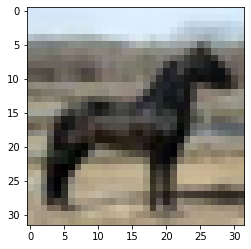

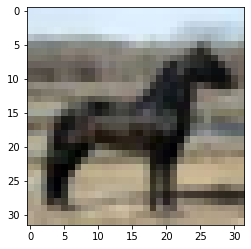

predicted horse
true horse
****************************************************************************************************


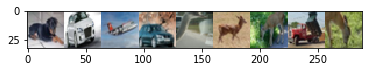

tensor([1.5181e-04, 1.3915e-04, 5.7430e-05, 2.8179e-05, 1.3973e-05, 1.0415e-04,
        3.0339e-04, 9.9919e-01, 1.0798e-05], device='cuda:0',
       dtype=torch.float64)


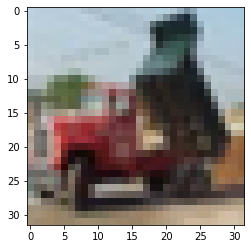

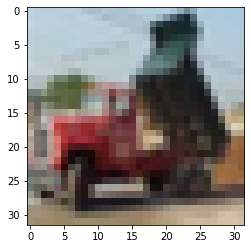

predicted truck
true truck
****************************************************************************************************


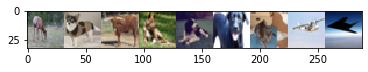

tensor([4.1202e-04, 8.9488e-05, 9.9906e-01, 5.0157e-05, 5.8104e-05, 1.1605e-04,
        9.7409e-05, 7.6820e-05, 3.9364e-05], device='cuda:0',
       dtype=torch.float64)


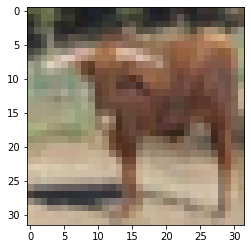

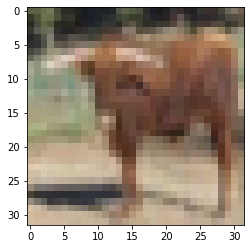

predicted horse
true horse
****************************************************************************************************


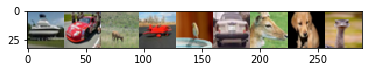

tensor([7.1400e-01, 1.2331e-05, 1.3670e-05, 2.8580e-01, 1.0668e-05, 1.5251e-04,
        5.8791e-06, 6.7772e-07, 7.8445e-06], device='cuda:0',
       dtype=torch.float64)


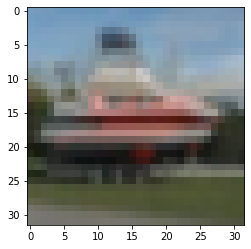

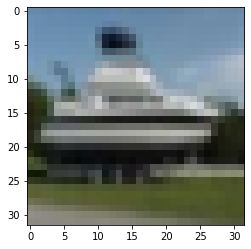

predicted ship
true ship
****************************************************************************************************


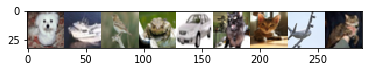

tensor([1.0120e-04, 9.9590e-01, 2.0241e-04, 5.9727e-04, 1.3033e-04, 1.4099e-04,
        4.3015e-04, 6.9898e-05, 2.4326e-03], device='cuda:0',
       dtype=torch.float64)


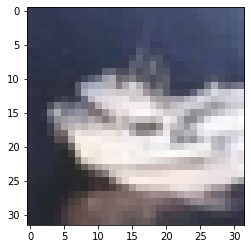

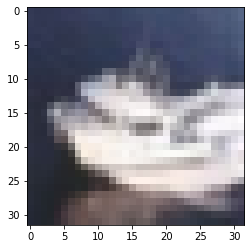

predicted ship
true ship
****************************************************************************************************


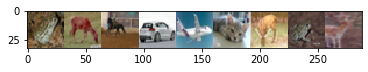

tensor([0.0439, 0.3553, 0.1590, 0.0621, 0.0487, 0.2053, 0.0448, 0.0317, 0.0493],
       device='cuda:0', dtype=torch.float64)


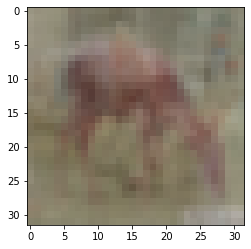

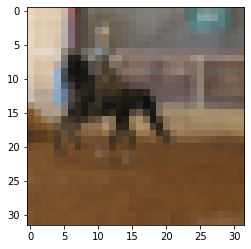

predicted horse
true horse
****************************************************************************************************


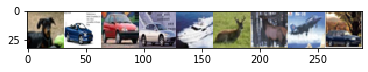

tensor([3.9473e-03, 4.7693e-02, 5.9388e-03, 5.8836e-04, 8.8394e-01, 1.5276e-03,
        4.0236e-02, 9.3437e-03, 6.7814e-03], device='cuda:0',
       dtype=torch.float64)


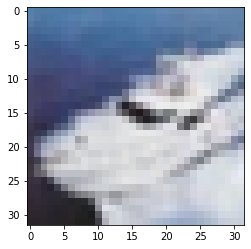

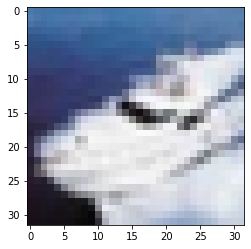

predicted ship
true ship
****************************************************************************************************


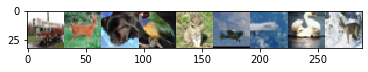

tensor([9.9628e-01, 5.6673e-05, 1.1188e-05, 2.0901e-05, 1.0858e-05, 3.1201e-03,
        9.8772e-05, 3.7662e-05, 3.6593e-04], device='cuda:0',
       dtype=torch.float64)


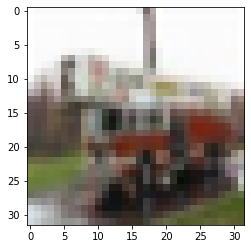

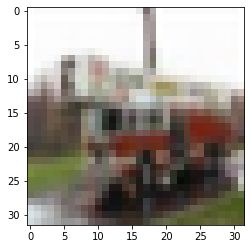

predicted truck
true truck
****************************************************************************************************


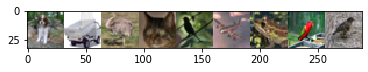

tensor([1.2579e-05, 9.9884e-01, 6.2907e-05, 3.5914e-05, 1.4115e-05, 3.0748e-04,
        2.5444e-05, 6.4754e-04, 5.3039e-05], device='cuda:0',
       dtype=torch.float64)


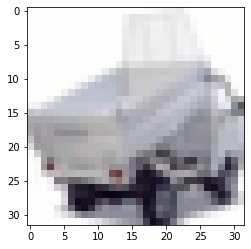

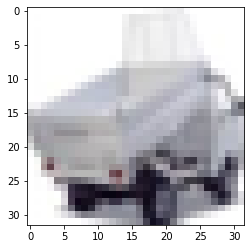

predicted truck
true truck
****************************************************************************************************


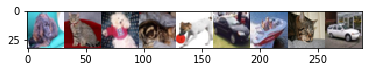

tensor([1.3173e-04, 1.0863e-04, 8.6478e-04, 4.1975e-03, 8.6993e-05, 1.0190e-03,
        9.8825e-01, 5.2270e-03, 1.1519e-04], device='cuda:0',
       dtype=torch.float64)


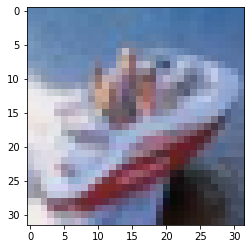

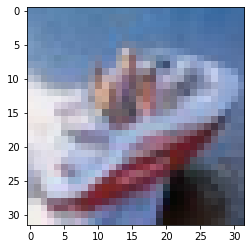

predicted ship
true ship
****************************************************************************************************


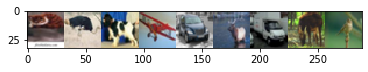

tensor([0.0017, 0.0012, 0.0197, 0.0033, 0.0050, 0.1455, 0.5685, 0.2443, 0.0107],
       device='cuda:0', dtype=torch.float64)


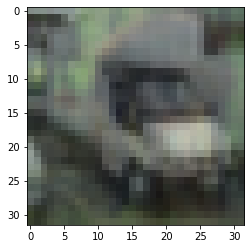

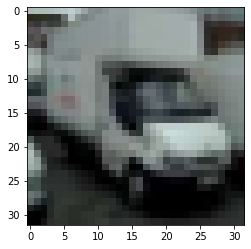

predicted truck
true truck
****************************************************************************************************


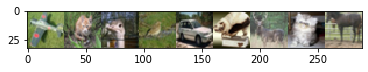

tensor([2.6367e-05, 5.9250e-05, 9.8914e-05, 3.0428e-05, 3.3383e-05, 1.8066e-03,
        3.9528e-04, 4.7211e-05, 9.9750e-01], device='cuda:0',
       dtype=torch.float64)


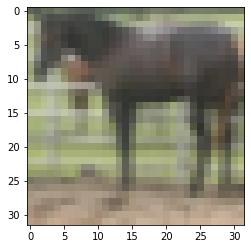

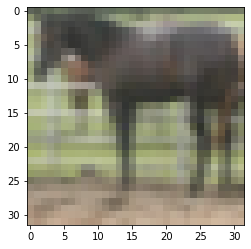

predicted horse
true horse
****************************************************************************************************


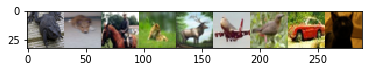

tensor([6.2211e-02, 2.4879e-03, 9.0674e-01, 3.5436e-03, 1.0876e-02, 1.9465e-03,
        1.1381e-02, 3.0499e-04, 5.0953e-04], device='cuda:0',
       dtype=torch.float64)


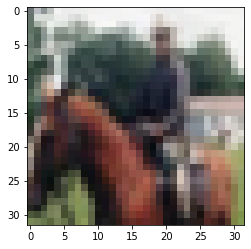

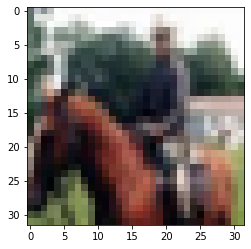

predicted horse
true horse
****************************************************************************************************


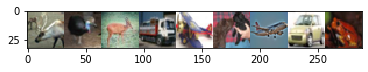

tensor([1.2530e-04, 3.6316e-04, 3.9833e-04, 9.9835e-01, 4.7529e-04, 3.2651e-05,
        1.0381e-04, 9.5875e-05, 5.5780e-05], device='cuda:0',
       dtype=torch.float64)


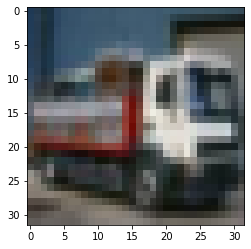

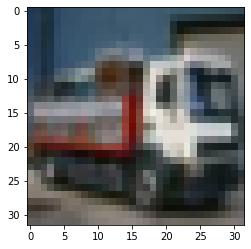

predicted truck
true truck
****************************************************************************************************


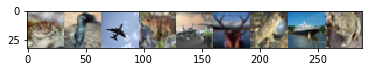

tensor([3.6787e-03, 9.7973e-03, 4.7990e-04, 5.1913e-02, 7.4156e-02, 5.8293e-02,
        1.3857e-03, 7.7951e-01, 2.0786e-02], device='cuda:0',
       dtype=torch.float64)


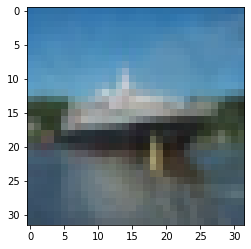

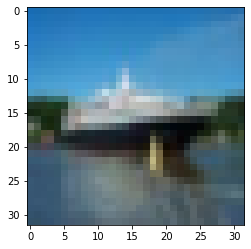

predicted ship
true ship
****************************************************************************************************


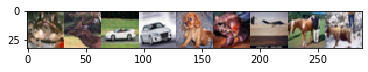

tensor([7.7317e-06, 4.1497e-06, 2.0367e-06, 1.0373e-06, 5.4224e-06, 9.4849e-05,
        5.9562e-04, 9.9927e-01, 1.7020e-05], device='cuda:0',
       dtype=torch.float64)


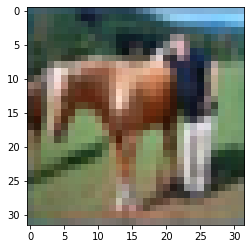

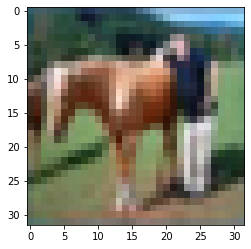

predicted horse
true horse
****************************************************************************************************


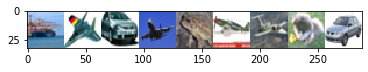

tensor([9.9846e-01, 3.5346e-04, 2.2623e-06, 6.4742e-06, 3.4388e-04, 1.4180e-04,
        3.3331e-04, 2.4015e-04, 1.1595e-04], device='cuda:0',
       dtype=torch.float64)


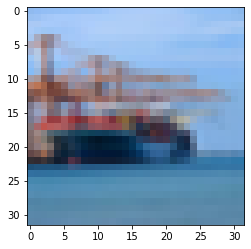

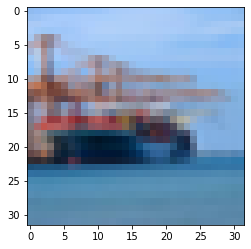

predicted ship
true ship
****************************************************************************************************


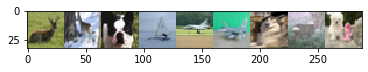

tensor([3.0575e-03, 1.0259e-01, 5.7339e-04, 8.3639e-01, 2.1060e-02, 3.5552e-03,
        2.1380e-03, 2.7429e-02, 3.2100e-03], device='cuda:0',
       dtype=torch.float64)


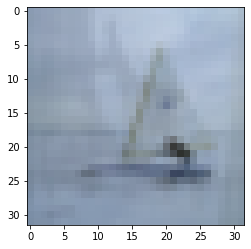

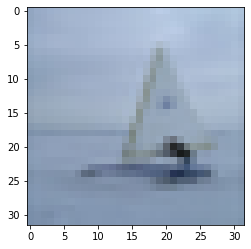

predicted ship
true ship
****************************************************************************************************


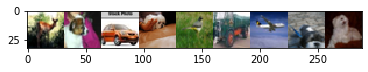

tensor([1.2645e-04, 4.4483e-04, 9.1216e-04, 3.7062e-04, 1.0969e-04, 9.9742e-01,
        3.0369e-04, 2.1109e-04, 1.0121e-04], device='cuda:0',
       dtype=torch.float64)


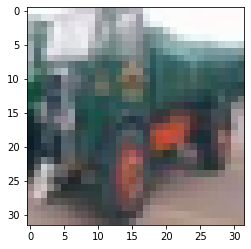

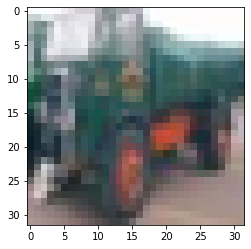

predicted truck
true truck
****************************************************************************************************


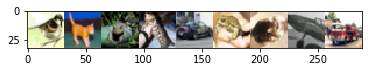

tensor([1.5004e-04, 3.5655e-03, 8.2569e-04, 1.4897e-02, 8.5412e-04, 4.2005e-05,
        1.2999e-03, 2.8184e-04, 9.7808e-01], device='cuda:0',
       dtype=torch.float64)


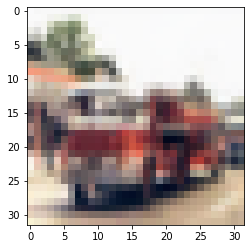

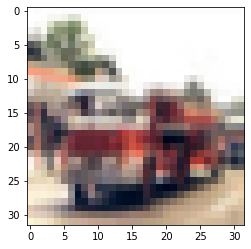

predicted truck
true truck
****************************************************************************************************


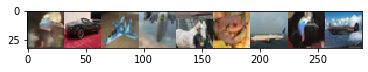

tensor([0.0317, 0.0107, 0.0212, 0.0114, 0.0169, 0.0034, 0.0847, 0.7662, 0.0537],
       device='cuda:0', dtype=torch.float64)


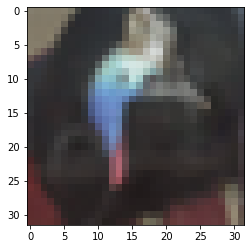

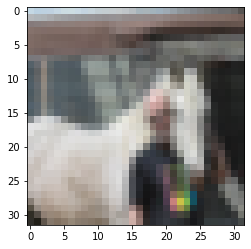

predicted horse
true horse
****************************************************************************************************


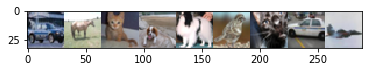

tensor([4.0983e-04, 9.7984e-01, 1.9789e-03, 1.1020e-04, 3.5281e-05, 2.9387e-04,
        1.5218e-02, 1.9825e-03, 1.3268e-04], device='cuda:0',
       dtype=torch.float64)


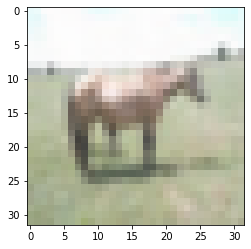

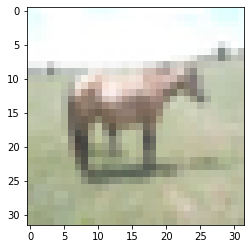

predicted horse
true horse
****************************************************************************************************


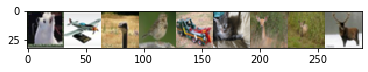

tensor([1.7572e-03, 7.3659e-04, 5.3693e-04, 4.4516e-04, 9.9246e-01, 1.1136e-03,
        8.1892e-04, 1.8882e-03, 2.4136e-04], device='cuda:0',
       dtype=torch.float64)


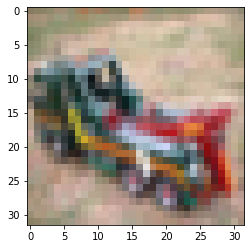

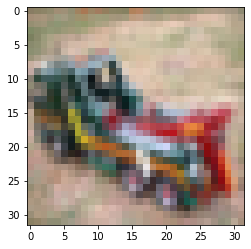

predicted truck
true truck
****************************************************************************************************


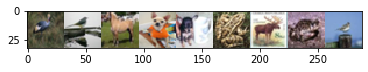

tensor([4.2728e-02, 1.0537e-02, 9.1680e-01, 6.2016e-04, 2.5072e-03, 7.1896e-03,
        4.3977e-03, 1.9110e-03, 1.3313e-02], device='cuda:0',
       dtype=torch.float64)


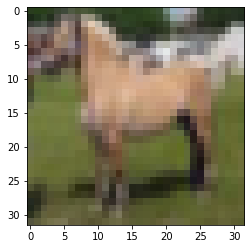

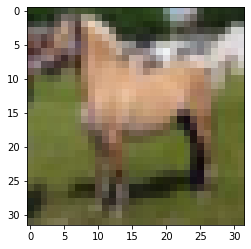

predicted horse
true horse
****************************************************************************************************


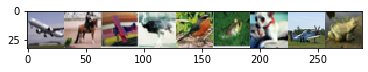

tensor([1.6980e-04, 9.8676e-01, 7.7341e-03, 2.2907e-04, 3.8594e-04, 2.4767e-03,
        6.9648e-05, 1.5691e-03, 6.0527e-04], device='cuda:0',
       dtype=torch.float64)


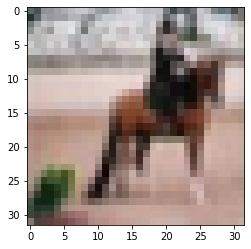

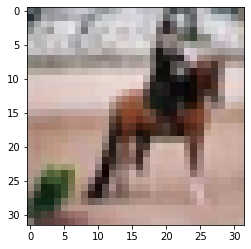

predicted horse
true horse
****************************************************************************************************


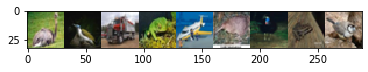

tensor([4.5626e-07, 5.3131e-06, 9.9994e-01, 1.2202e-05, 2.0309e-06, 6.1311e-06,
        2.6389e-05, 5.1552e-06, 6.1537e-06], device='cuda:0',
       dtype=torch.float64)


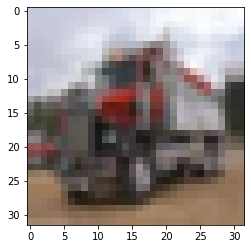

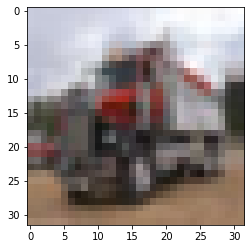

predicted truck
true truck
****************************************************************************************************


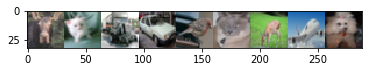

tensor([4.1407e-06, 4.3626e-06, 9.9990e-01, 1.4418e-06, 1.5219e-06, 7.6499e-06,
        8.5125e-07, 7.0889e-05, 5.2259e-06], device='cuda:0',
       dtype=torch.float64)


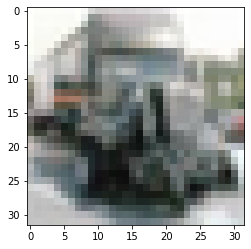

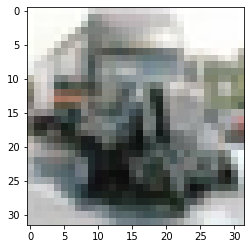

predicted truck
true truck
****************************************************************************************************


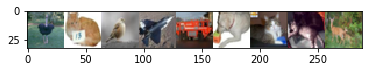

tensor([0.0325, 0.0018, 0.0668, 0.0205, 0.8560, 0.0134, 0.0020, 0.0030, 0.0040],
       device='cuda:0', dtype=torch.float64)


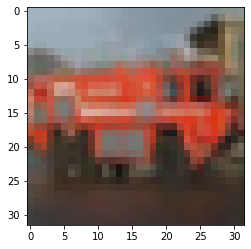

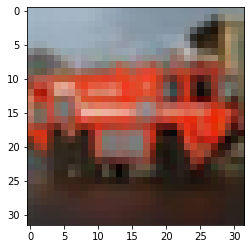

predicted truck
true truck
****************************************************************************************************


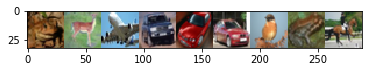

tensor([7.7345e-03, 2.4973e-03, 2.1338e-01, 7.1442e-04, 3.5630e-03, 8.8868e-04,
        2.3598e-02, 4.2336e-04, 7.4720e-01], device='cuda:0',
       dtype=torch.float64)


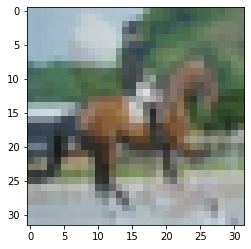

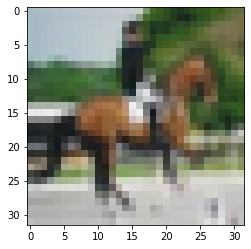

predicted horse
true horse
****************************************************************************************************


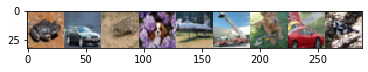

tensor([0.0335, 0.0071, 0.0265, 0.0010, 0.0539, 0.0146, 0.0639, 0.7761, 0.0232],
       device='cuda:0', dtype=torch.float64)


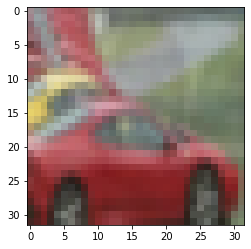

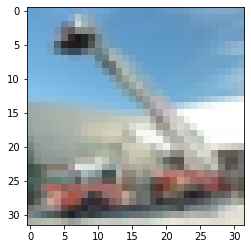

predicted truck
true truck
****************************************************************************************************


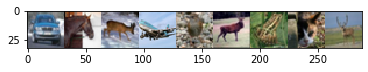

tensor([0.0586, 0.6639, 0.0960, 0.0032, 0.0874, 0.0255, 0.0011, 0.0259, 0.0383],
       device='cuda:0', dtype=torch.float64)


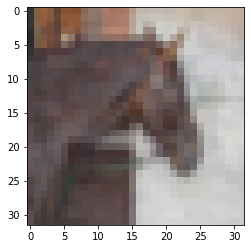

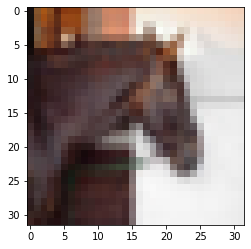

predicted horse
true horse
****************************************************************************************************


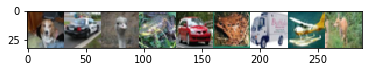

tensor([4.1977e-04, 3.2410e-02, 3.8540e-03, 1.3235e-02, 1.3645e-02, 1.2812e-03,
        9.1575e-01, 1.3870e-02, 5.5346e-03], device='cuda:0',
       dtype=torch.float64)


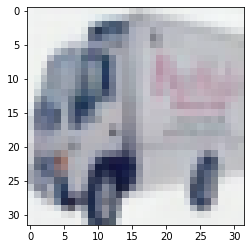

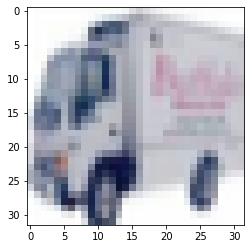

predicted truck
true truck
Accuracy of the network on the 30000 train images: 97 %
total correct 29308
total train set images 30000
focus_true_pred_true 45
focus_false_pred_true 5
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 47
argmax_less_than_half 3


In [31]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

6


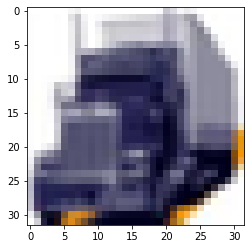

truck


In [34]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


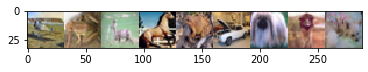

tensor([1.5332e-02, 1.4475e-03, 2.2587e-03, 8.6811e-01, 5.2585e-04, 4.6520e-04,
        9.0314e-02, 1.2211e-03, 2.0322e-02], device='cuda:0',
       dtype=torch.float64)


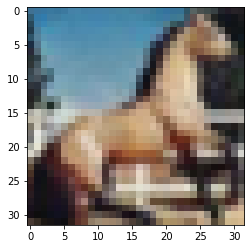

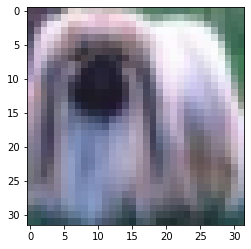

predicted horse
true horse
****************************************************************************************************


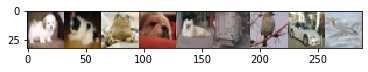

tensor([0.0188, 0.0045, 0.0136, 0.0017, 0.0195, 0.7415, 0.1780, 0.0136, 0.0088],
       device='cuda:0', dtype=torch.float64)


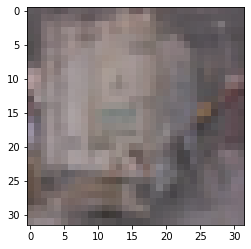

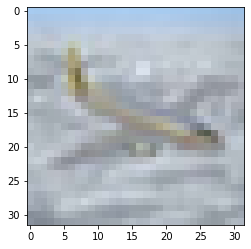

predicted horse
true truck
****************************************************************************************************


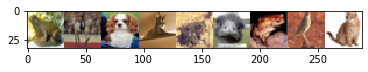

tensor([0.0137, 0.4452, 0.0030, 0.3688, 0.0644, 0.0595, 0.0029, 0.0129, 0.0296],
       device='cuda:0', dtype=torch.float64)


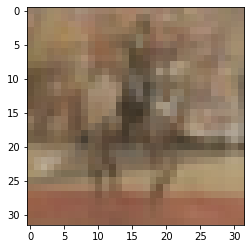

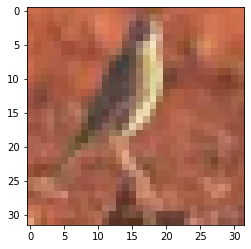

predicted horse
true horse
****************************************************************************************************


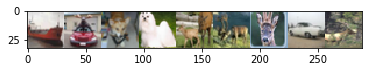

tensor([0.7562, 0.0303, 0.0065, 0.0139, 0.0787, 0.0440, 0.0204, 0.0356, 0.0143],
       device='cuda:0', dtype=torch.float64)


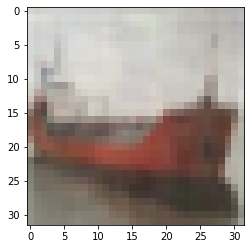

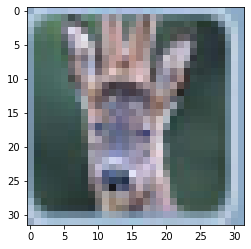

predicted ship
true ship
****************************************************************************************************


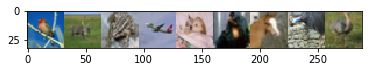

tensor([3.4503e-04, 5.4011e-03, 3.3108e-02, 2.0123e-03, 7.4217e-03, 1.2525e-02,
        8.6660e-01, 6.9458e-02, 3.1339e-03], device='cuda:0',
       dtype=torch.float64)


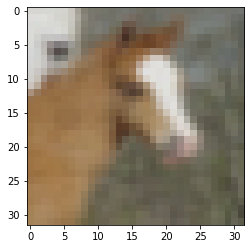

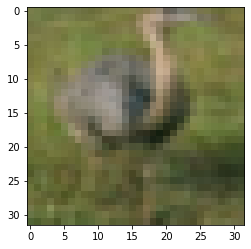

predicted horse
true horse
****************************************************************************************************


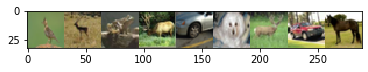

tensor([4.1440e-08, 3.2068e-08, 1.9627e-07, 1.2687e-07, 3.1245e-08, 6.9102e-07,
        1.1528e-07, 1.2533e-07, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


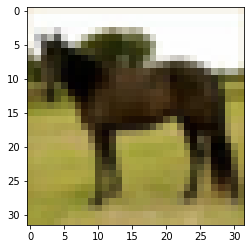

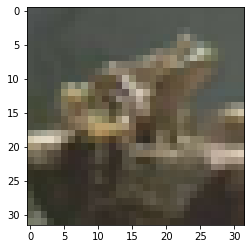

predicted horse
true horse
****************************************************************************************************


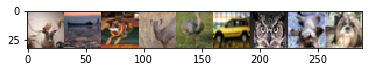

tensor([4.0169e-03, 9.5649e-01, 3.1341e-03, 1.5272e-02, 4.9665e-03, 3.3882e-03,
        8.0245e-03, 3.9834e-03, 7.2570e-04], device='cuda:0',
       dtype=torch.float64)


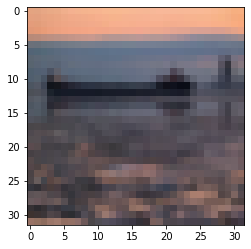

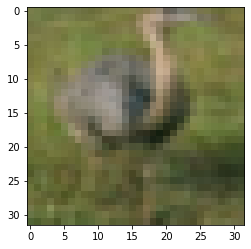

predicted ship
true ship
****************************************************************************************************


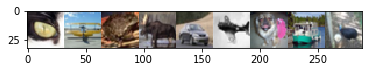

tensor([9.8120e-06, 7.8194e-05, 5.7108e-07, 2.7230e-04, 1.7619e-06, 2.4119e-06,
        2.5902e-06, 9.9958e-01, 5.0206e-05], device='cuda:0',
       dtype=torch.float64)


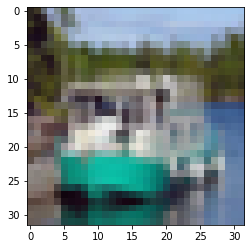

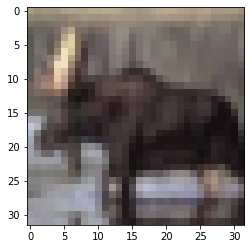

predicted ship
true ship
****************************************************************************************************


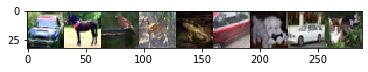

tensor([3.5866e-08, 1.0000e+00, 2.6906e-08, 7.6310e-07, 2.6984e-08, 7.2042e-09,
        8.9281e-09, 6.2817e-08, 9.2611e-08], device='cuda:0',
       dtype=torch.float64)


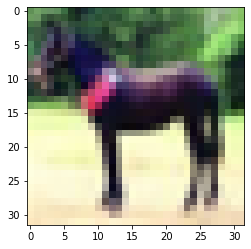

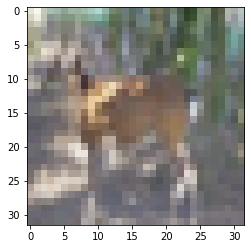

predicted horse
true horse
****************************************************************************************************


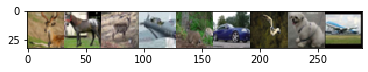

tensor([3.4724e-04, 9.3309e-01, 1.4707e-03, 3.1115e-02, 2.0215e-03, 3.6787e-03,
        2.4698e-02, 2.8901e-03, 6.8714e-04], device='cuda:0',
       dtype=torch.float64)


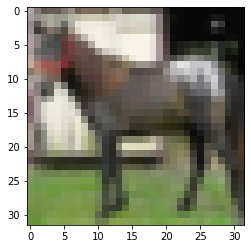

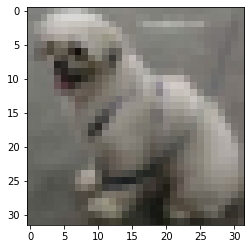

predicted horse
true horse
****************************************************************************************************


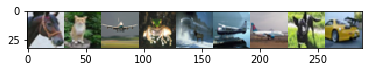

tensor([0.3245, 0.0091, 0.0821, 0.3451, 0.0107, 0.0144, 0.0168, 0.1923, 0.0050],
       device='cuda:0', dtype=torch.float64)


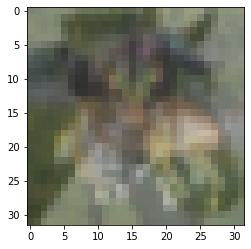

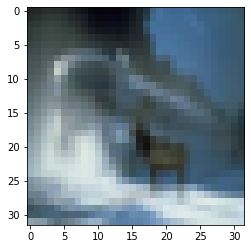

predicted horse
true horse
****************************************************************************************************


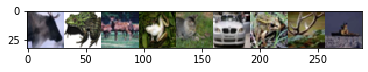

tensor([0.5290, 0.0035, 0.0586, 0.0018, 0.0107, 0.0071, 0.0024, 0.0280, 0.3588],
       device='cuda:0', dtype=torch.float64)


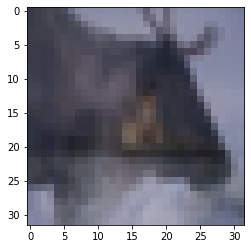

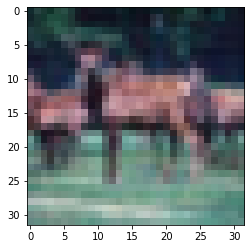

predicted horse
true ship
****************************************************************************************************


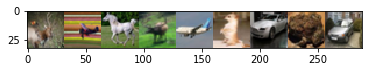

tensor([0.0263, 0.0677, 0.7952, 0.0470, 0.0040, 0.0025, 0.0081, 0.0063, 0.0429],
       device='cuda:0', dtype=torch.float64)


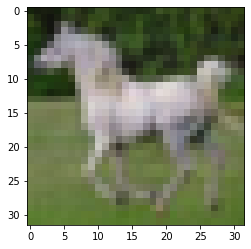

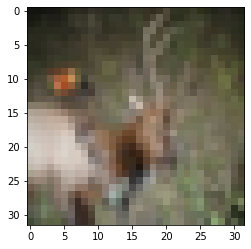

predicted horse
true horse
****************************************************************************************************


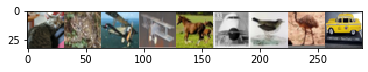

tensor([8.2089e-05, 1.9850e-04, 4.0601e-04, 1.0119e-03, 9.9732e-01, 1.7560e-04,
        4.6101e-05, 6.0564e-04, 1.5525e-04], device='cuda:0',
       dtype=torch.float64)


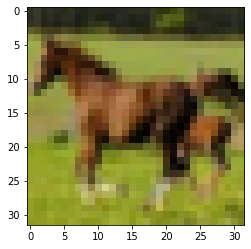

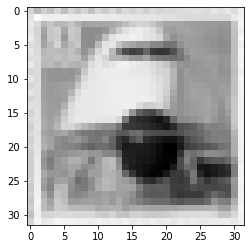

predicted horse
true horse
****************************************************************************************************


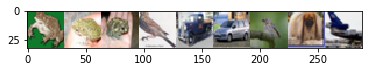

tensor([1.7524e-03, 1.5205e-04, 3.9521e-04, 2.6648e-04, 9.8628e-01, 5.0316e-04,
        1.0359e-03, 3.1486e-03, 6.4630e-03], device='cuda:0',
       dtype=torch.float64)


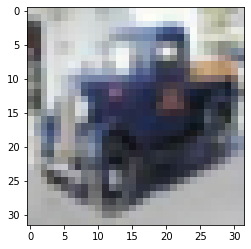

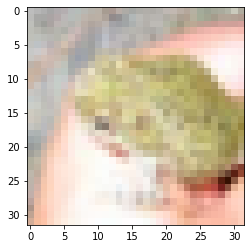

predicted truck
true truck
****************************************************************************************************


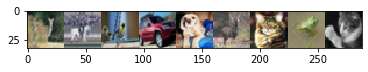

tensor([4.2290e-03, 9.5919e-01, 4.1571e-03, 1.1746e-02, 2.8228e-04, 9.1114e-04,
        1.2020e-02, 1.4195e-03, 6.0472e-03], device='cuda:0',
       dtype=torch.float64)


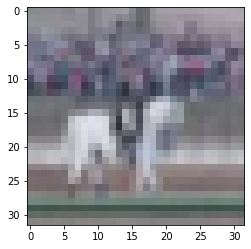

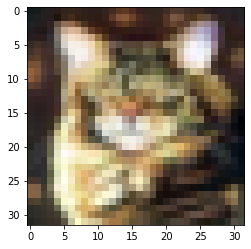

predicted horse
true horse
****************************************************************************************************


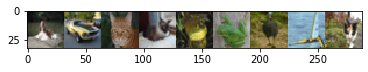

tensor([0.0013, 0.0042, 0.0014, 0.0013, 0.0023, 0.0101, 0.0019, 0.7895, 0.1880],
       device='cuda:0', dtype=torch.float64)


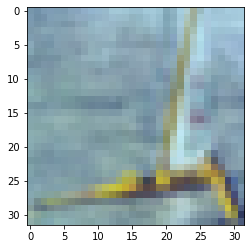

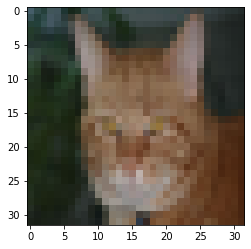

predicted ship
true ship
****************************************************************************************************


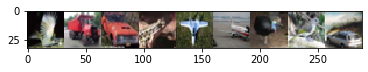

tensor([3.3588e-05, 9.1991e-01, 6.2172e-04, 4.1291e-04, 1.7490e-04, 7.2799e-02,
        2.8488e-03, 1.8993e-04, 3.0094e-03], device='cuda:0',
       dtype=torch.float64)


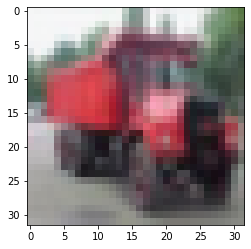

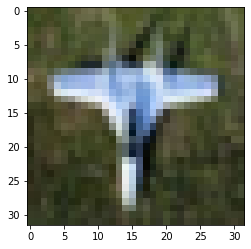

predicted truck
true truck
****************************************************************************************************


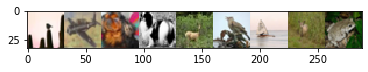

tensor([0.0250, 0.0226, 0.2482, 0.1886, 0.0071, 0.2525, 0.0466, 0.0339, 0.1755],
       device='cuda:0', dtype=torch.float64)


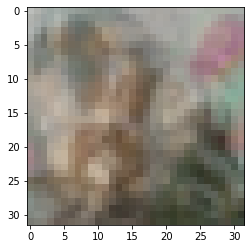

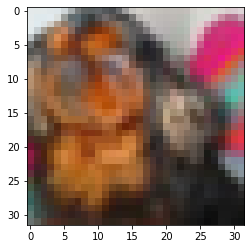

predicted horse
true ship
****************************************************************************************************


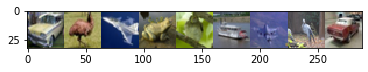

tensor([0.0423, 0.0064, 0.0032, 0.0208, 0.0021, 0.8016, 0.0444, 0.0381, 0.0410],
       device='cuda:0', dtype=torch.float64)


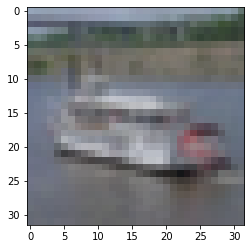

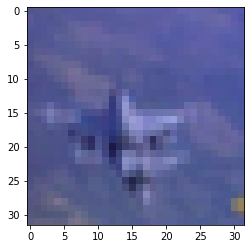

predicted ship
true ship
****************************************************************************************************


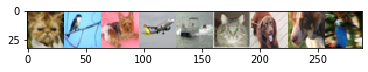

tensor([0.1122, 0.0122, 0.0286, 0.0110, 0.3135, 0.0708, 0.1949, 0.2429, 0.0140],
       device='cuda:0', dtype=torch.float64)


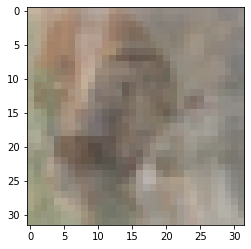

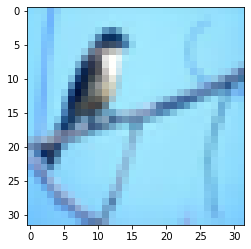

predicted horse
true ship
****************************************************************************************************


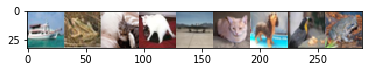

tensor([9.8640e-01, 8.6627e-05, 8.9710e-03, 7.0475e-05, 2.3333e-03, 1.4182e-03,
        8.3091e-05, 5.6927e-04, 7.0555e-05], device='cuda:0',
       dtype=torch.float64)


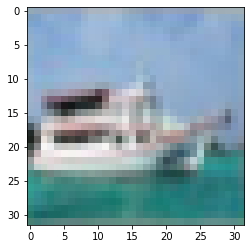

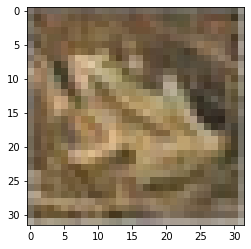

predicted ship
true ship
****************************************************************************************************


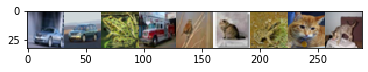

tensor([4.9989e-05, 2.9261e-04, 1.7659e-05, 9.9840e-01, 9.9560e-05, 2.5032e-04,
        2.0767e-05, 1.7271e-04, 6.9210e-04], device='cuda:0',
       dtype=torch.float64)


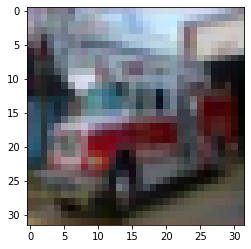

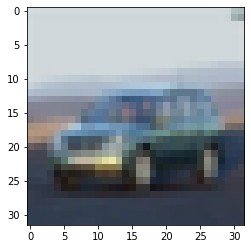

predicted truck
true truck
****************************************************************************************************


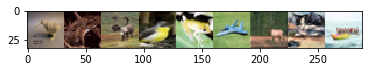

tensor([6.2474e-03, 4.3941e-04, 7.5791e-04, 3.4631e-04, 6.5740e-03, 2.3467e-04,
        5.4225e-02, 2.2715e-02, 9.0846e-01], device='cuda:0',
       dtype=torch.float64)


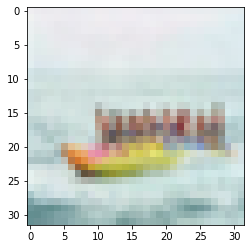

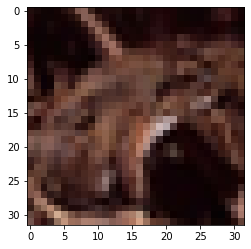

predicted ship
true ship
****************************************************************************************************


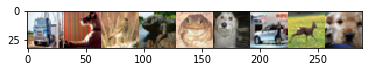

tensor([9.9893e-01, 2.7790e-04, 1.0502e-05, 1.5908e-05, 9.8977e-06, 1.9963e-04,
        4.3412e-04, 4.2930e-05, 8.1034e-05], device='cuda:0',
       dtype=torch.float64)


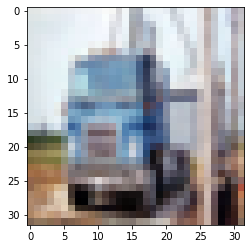

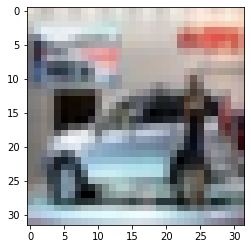

predicted truck
true truck
****************************************************************************************************


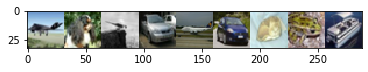

tensor([7.7910e-04, 2.9483e-04, 2.0378e-03, 1.5891e-02, 7.6574e-03, 7.7185e-03,
        4.7410e-04, 1.0824e-03, 9.6406e-01], device='cuda:0',
       dtype=torch.float64)


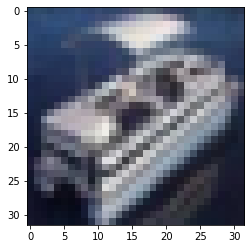

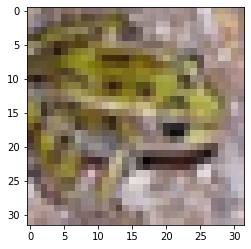

predicted ship
true ship
****************************************************************************************************


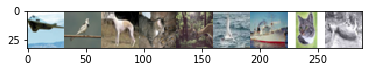

tensor([7.1592e-07, 1.9666e-06, 3.2189e-05, 5.8610e-07, 5.8059e-06, 1.2638e-05,
        9.9993e-01, 2.3703e-06, 1.6785e-05], device='cuda:0',
       dtype=torch.float64)


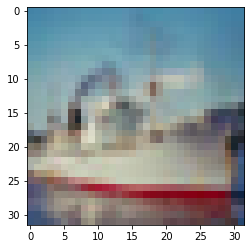

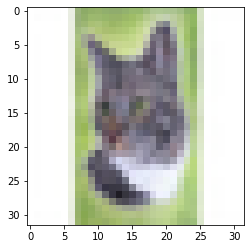

predicted ship
true ship
****************************************************************************************************


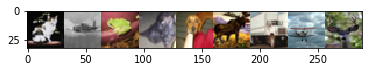

tensor([8.2953e-04, 5.3468e-04, 8.6931e-04, 1.4523e-03, 1.7320e-05, 1.1100e-04,
        9.9425e-01, 1.6640e-03, 2.6995e-04], device='cuda:0',
       dtype=torch.float64)


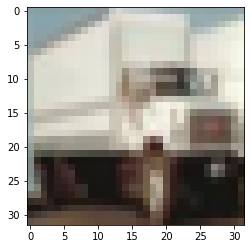

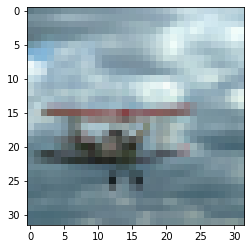

predicted truck
true truck
****************************************************************************************************


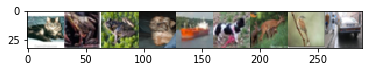

tensor([1.5975e-04, 2.3636e-04, 9.4299e-04, 1.4395e-04, 9.7171e-01, 2.0396e-03,
        8.5642e-04, 1.6757e-03, 2.2238e-02], device='cuda:0',
       dtype=torch.float64)


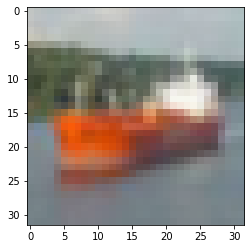

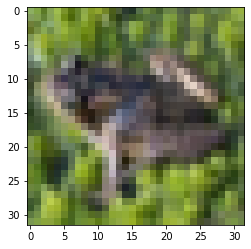

predicted ship
true ship
****************************************************************************************************


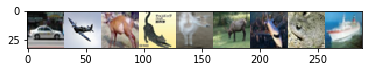

tensor([6.1588e-04, 3.1749e-05, 8.6216e-04, 1.2230e-04, 3.6896e-04, 2.0139e-03,
        2.0401e-04, 8.0114e-05, 9.9570e-01], device='cuda:0',
       dtype=torch.float64)


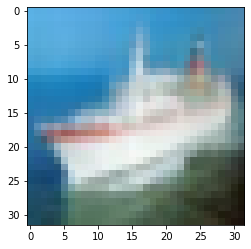

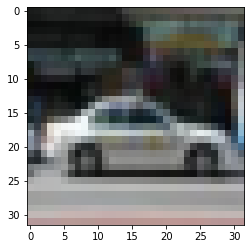

predicted ship
true ship
****************************************************************************************************


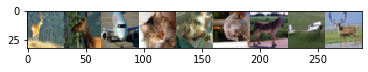

tensor([0.1602, 0.0300, 0.0126, 0.0075, 0.0154, 0.0009, 0.6530, 0.0445, 0.0760],
       device='cuda:0', dtype=torch.float64)


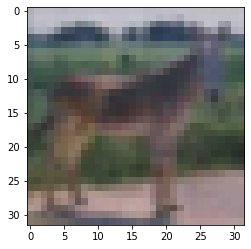

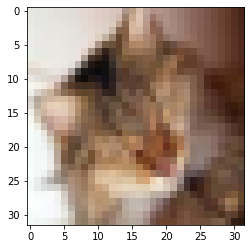

predicted horse
true horse
****************************************************************************************************


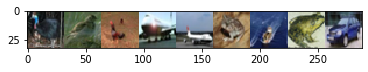

tensor([4.9544e-02, 3.2627e-03, 4.0753e-03, 7.2048e-03, 2.6259e-02, 3.2559e-04,
        9.0789e-01, 4.8396e-04, 9.5827e-04], device='cuda:0',
       dtype=torch.float64)


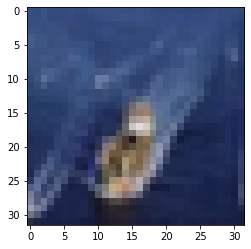

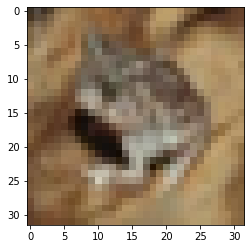

predicted ship
true ship
****************************************************************************************************


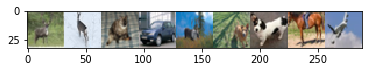

tensor([3.9795e-05, 1.6832e-06, 1.4871e-05, 1.2290e-05, 1.1024e-05, 8.4367e-06,
        1.6092e-06, 9.9991e-01, 2.9143e-06], device='cuda:0',
       dtype=torch.float64)


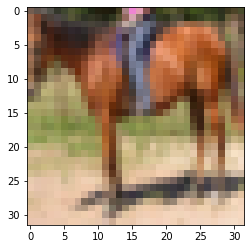

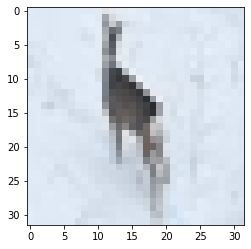

predicted horse
true horse
****************************************************************************************************


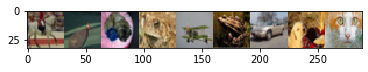

tensor([0.0253, 0.2993, 0.2494, 0.0722, 0.0591, 0.0388, 0.1800, 0.0069, 0.0689],
       device='cuda:0', dtype=torch.float64)


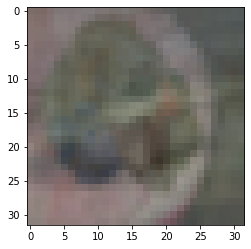

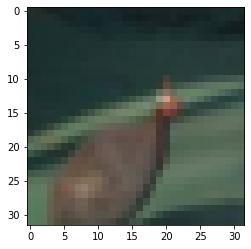

predicted truck
true horse
****************************************************************************************************


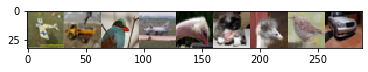

tensor([3.8666e-04, 9.8081e-01, 3.1846e-04, 1.5468e-03, 2.2738e-03, 4.1967e-04,
        3.8279e-04, 1.2486e-02, 1.3753e-03], device='cuda:0',
       dtype=torch.float64)


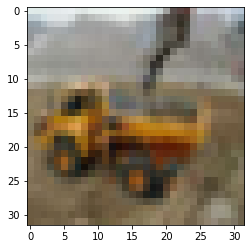

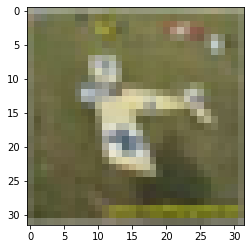

predicted truck
true truck
****************************************************************************************************


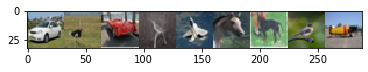

tensor([0.0276, 0.0412, 0.0573, 0.0151, 0.0021, 0.0504, 0.5373, 0.0483, 0.2207],
       device='cuda:0', dtype=torch.float64)


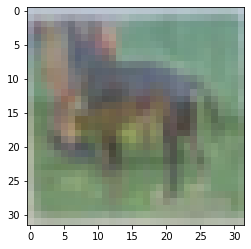

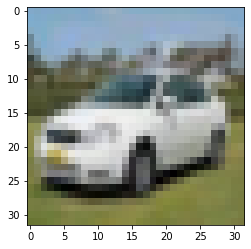

predicted horse
true horse
****************************************************************************************************


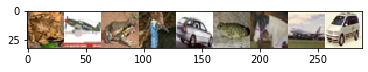

tensor([0.1738, 0.1024, 0.0072, 0.0438, 0.1127, 0.1130, 0.0733, 0.2510, 0.1230],
       device='cuda:0', dtype=torch.float64)


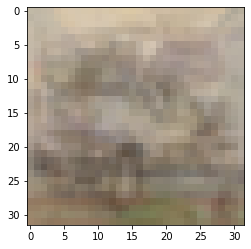

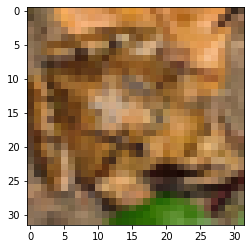

predicted horse
true horse
****************************************************************************************************


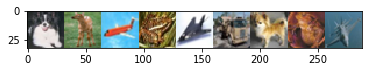

tensor([5.2723e-04, 6.2281e-04, 2.9818e-05, 3.7103e-05, 1.0869e-05, 9.9853e-01,
        7.4141e-05, 3.9783e-05, 1.2505e-04], device='cuda:0',
       dtype=torch.float64)


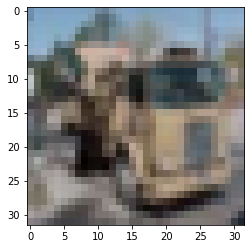

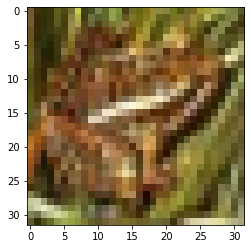

predicted truck
true truck
****************************************************************************************************


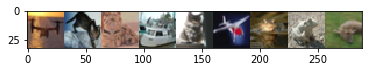

tensor([0.1196, 0.0157, 0.0048, 0.1947, 0.6159, 0.0011, 0.0067, 0.0105, 0.0309],
       device='cuda:0', dtype=torch.float64)


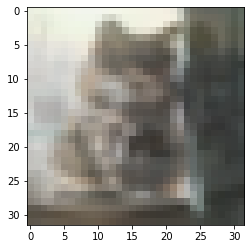

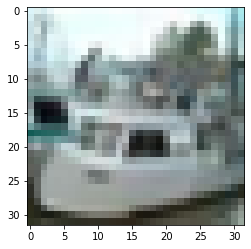

predicted horse
true ship
****************************************************************************************************


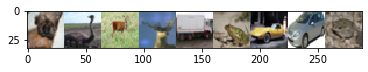

tensor([8.6067e-05, 1.7497e-03, 1.5914e-04, 4.5149e-04, 9.9688e-01, 2.4483e-04,
        1.3727e-04, 9.0132e-05, 1.9678e-04], device='cuda:0',
       dtype=torch.float64)


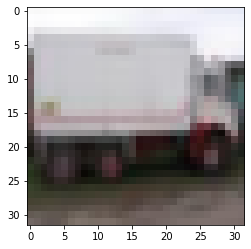

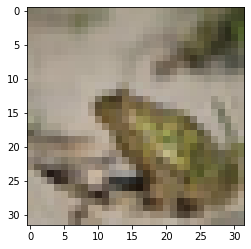

predicted truck
true truck
****************************************************************************************************


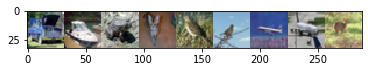

tensor([0.0609, 0.6874, 0.0996, 0.0319, 0.0074, 0.0034, 0.0458, 0.0304, 0.0331],
       device='cuda:0', dtype=torch.float64)


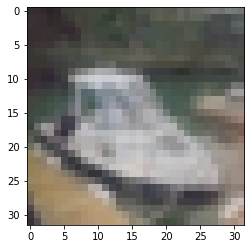

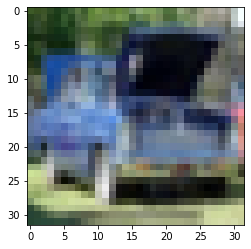

predicted ship
true ship
****************************************************************************************************


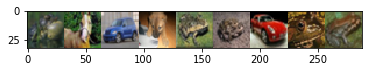

tensor([0.5943, 0.0089, 0.0069, 0.0206, 0.1976, 0.1167, 0.0395, 0.0082, 0.0074],
       device='cuda:0', dtype=torch.float64)


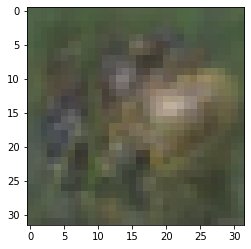

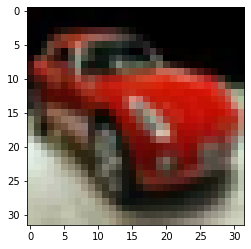

predicted horse
true horse
****************************************************************************************************


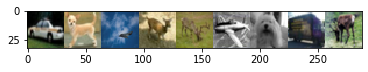

tensor([0.0271, 0.0076, 0.0078, 0.4645, 0.0060, 0.0023, 0.0293, 0.2891, 0.1662],
       device='cuda:0', dtype=torch.float64)


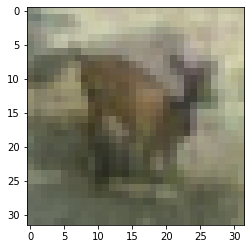

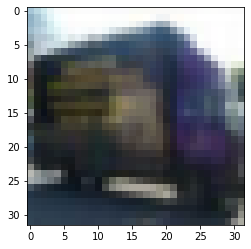

predicted horse
true truck
****************************************************************************************************


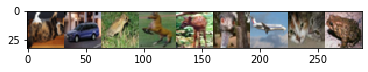

tensor([0.0120, 0.6936, 0.0008, 0.2381, 0.0038, 0.0349, 0.0059, 0.0059, 0.0049],
       device='cuda:0', dtype=torch.float64)


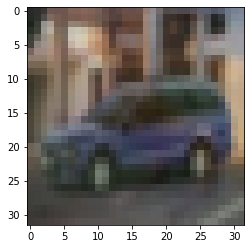

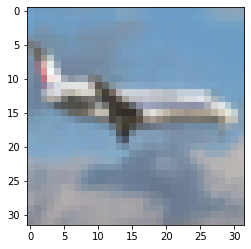

predicted truck
true horse
****************************************************************************************************


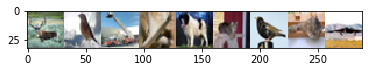

tensor([6.3570e-03, 2.1794e-02, 7.5815e-03, 5.2378e-04, 9.1925e-01, 2.3228e-02,
        4.4242e-03, 3.3026e-03, 1.3540e-02], device='cuda:0',
       dtype=torch.float64)


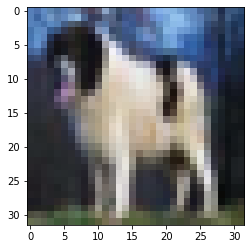

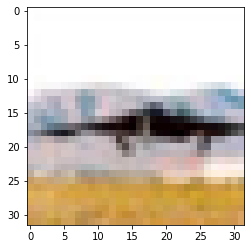

predicted horse
true truck
****************************************************************************************************


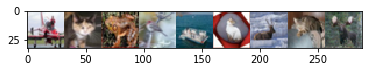

tensor([0.0600, 0.0006, 0.0019, 0.0019, 0.6235, 0.0062, 0.0094, 0.0841, 0.2125],
       device='cuda:0', dtype=torch.float64)


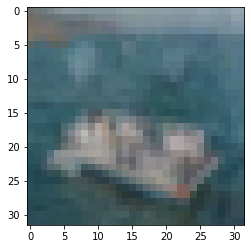

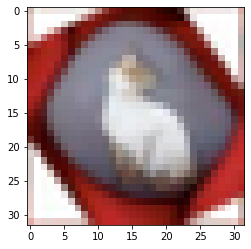

predicted ship
true ship
****************************************************************************************************


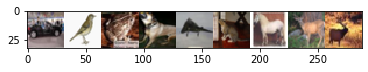

tensor([8.4675e-03, 4.2199e-05, 1.2283e-04, 8.8529e-03, 2.0299e-03, 1.2712e-03,
        9.7618e-01, 2.1399e-03, 8.9283e-04], device='cuda:0',
       dtype=torch.float64)


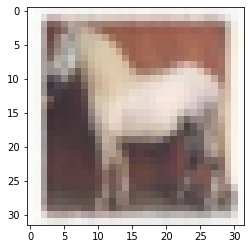

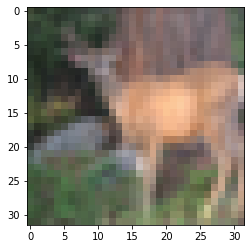

predicted horse
true horse
****************************************************************************************************


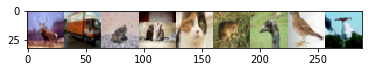

tensor([4.7727e-02, 8.7134e-01, 1.4082e-03, 7.5139e-02, 1.0773e-03, 2.6996e-04,
        6.8003e-04, 4.6961e-04, 1.8869e-03], device='cuda:0',
       dtype=torch.float64)


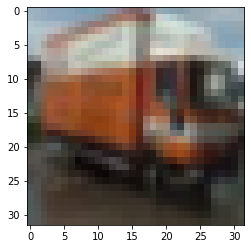

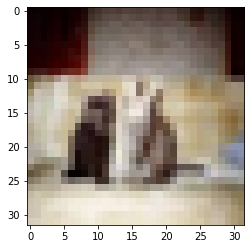

predicted truck
true truck
****************************************************************************************************


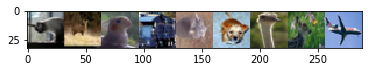

tensor([2.7512e-05, 5.8886e-06, 2.1513e-06, 9.9991e-01, 1.4228e-05, 1.0622e-06,
        5.6763e-06, 3.3759e-05, 3.7588e-07], device='cuda:0',
       dtype=torch.float64)


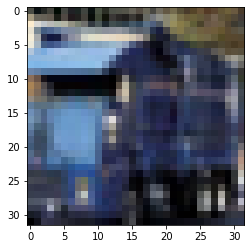

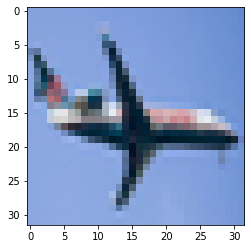

predicted truck
true truck
****************************************************************************************************


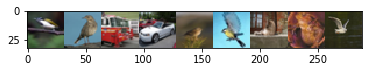

tensor([1.7053e-01, 1.1873e-03, 5.5747e-01, 2.2685e-04, 1.0613e-02, 2.7056e-04,
        2.5423e-01, 8.6255e-04, 4.6027e-03], device='cuda:0',
       dtype=torch.float64)


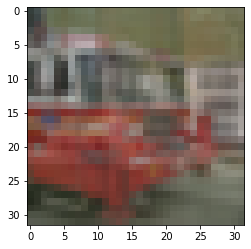

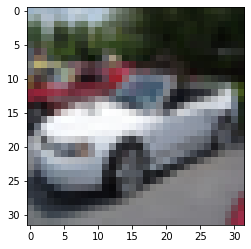

predicted truck
true truck
Accuracy of the network on the 10000 test images: 86 %
total correct 8634
total test set images 10000


In [35]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [37]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [38]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29308
total train set images 30000
focus_true_pred_true 25624
focus_false_pred_true 3684
focus_true_pred_false 113
focus_false_pred_false 579
argmax_more_than_half 27085
argmax_less_than_half 2915


In [39]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 86 %
total correct 8634
total train set images 10000
focus_true_pred_true 7726
focus_false_pred_true 908
focus_true_pred_false 230
focus_false_pred_false 1136
argmax_more_than_half 8629
argmax_less_than_half 1371


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)